This example uses trunk version of numba at Github.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numba import jit

The most important api of numba is the decorator: `jit`.

The `jit` decorator returns a compiled version of the function using the input types and the output types of the function.   You can optionally specify the type using `out_type(in_type, ...)` syntax.  Array inputs can be specified using `[:,:]` appended to the type.   If no type are specified, it watches for what types you call the function with and infers the type of the return.  If there is a previously compiled version of the code available it uses it, if not it generates machine code for the function and then executes that code. 

In [3]:
def sum(arr):
    M, N = arr.shape
    sum = 0.0
    for i in range(M):
        for j in range(N):
            sum += arr[i,j]
    return sum
fastsum = jit('f8(f8[:,:])')(sum)
flexsum = jit(sum)

In [4]:
arr2d = np.arange(600,dtype=float).reshape(20,30)
print(sum(arr2d))
print(fastsum(arr2d))
print(flexsum(arr2d))
print(flexsum(arr2d.astype(int)))

179700.0
179700.0
179700.0
179700.0


In [5]:
%timeit sum(arr2d)

10000 loops, best of 3: 135 µs per loop


In [6]:
%timeit fastsum(arr2d)

The slowest run took 8.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 827 ns per loop


In [7]:
%timeit arr2d.sum() 

The slowest run took 15.67 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.9 µs per loop


The speed-up is even more pronounced the more inner loops in the code.   Here is an image processing example:

In [8]:
@jit('(f8[:,:],f8[:,:],f8[:,:])')
def filter(image, filt, output):
    M, N = image.shape
    m, n = filt.shape
    for i in range(m//2, M-m//2):
        for j in range(n//2, N-n//2):
            result = 0.0
            for k in range(m):
                for l in range(n):
                    result += image[i+k-m//2,j+l-n//2]*filt[k, l]
            output[i,j] = result

try:
    # py2
    from urllib import urlopen
except ImportError:
    # py3
    from urllib.request import urlopen

bytes = urlopen('http://www.cs.tut.fi/~foi/SA-DCT/original/image_Lake512.png').read()            

from matplotlib.pyplot import imread

from io import BytesIO

image = imread(BytesIO(bytes)).astype('double')

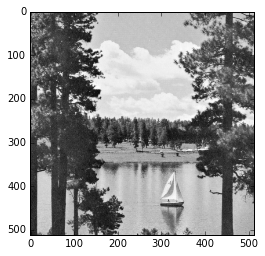

In [9]:
imshow(image)
gray()

Python: 1.250645 s; Numba: 2.591848 ms; Speed up is 482.530126


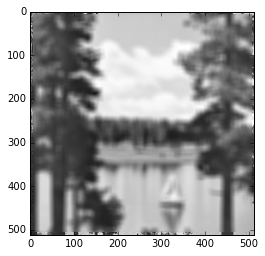

In [10]:
import time
filt = np.ones((15,15),dtype='double')
filt /= filt.sum()
output = image.copy()
filter(image, filt, output)
gray()
imshow(output)
start = time.time()
filter(image[:100,:100], filt, output[:100,:100])
fast = time.time() - start
start = time.time()
filter.py_func(image[:100,:100], filt, output[:100,:100])
slow = time.time() - start
print("Python: %f s; Numba: %f ms; Speed up is %f" % (slow, fast*1000, slow / fast))

You can call Numba-created functions from other Numba-created functions and get even more amazing speed-ups.

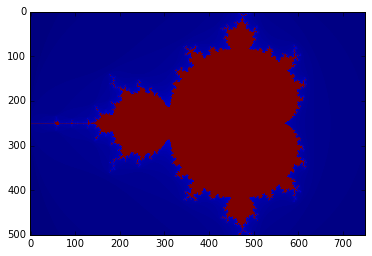

In [11]:
@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500, 750), dtype=np.uint8)
imshow(create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20))
jet()

In [12]:
%timeit create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

100 loops, best of 3: 12.5 ms per loop


In [13]:
%timeit create_fractal.py_func(-2.0, 1.0, -1.0, 1.0, image, 20)

10 loops, best of 3: 175 ms per loop


Basic complex support is available as well.  Some functions are still being implemented, however.

In [14]:
@jit
def complex_support(real, imag):
    c = complex(real, imag)
    return (c ** 2).conjugate()

c = 2.0 + 4.0j
complex_support(c.real, c.imag), (c**2).conjugate()

((-12-16j), (-12-16j))

We can even create a function that takes a structured array as input.

In [15]:
from numba import jit, typeof
import numpy as np

record_dtype = np.dtype([('x', np.float64), ('y', np.float64)], align=True)
record_type = typeof(record_dtype)
a = np.array([(1.0, 2.0), (3.0, 4.0)], dtype=record_dtype)

@jit
def hypot(data):
    # return types of numpy functions are inferred
    result = np.empty_like(data, dtype=np.float64)
    # notice access to structure elements 'x' and 'y' via attribute access
    # You can also index by field name or field index:
    #       data[i].x == data[i]['x'] == data[i][0]
    for i in range(data.shape[0]):
        result[i] = np.sqrt(data[i].x * data[i].x + data[i].y * data[i].y)

    return result

print(hypot(a))

# Notice inferred return type
print(hypot.signatures)
# Notice native sqrt calls and for.body direct access to memory...
llvmir = hypot.inspect_llvm(hypot.signatures[0])
print(llvmir)

[ 2.23606798  5.        ]
[(array(Record([('x', '<f8'), ('y', '<f8')]), 1d, C),)]
; ModuleID = 'hypot'
target datalayout = "e-m:o-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-apple-darwin15.3.0"

@.const.hypot = internal constant [6 x i8] c"hypot\00"
@".const.Fatal error: missing _dynfunc.Closure" = internal constant [38 x i8] c"Fatal error: missing _dynfunc.Closure\00"
@PyExc_RuntimeError = external global i8
@".const.missing Environment" = internal constant [20 x i8] c"missing Environment\00"

define i32 @"__main__.hypot$8.array(Record_515,_1d,_C)"({ i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64] }* noalias nocapture %retptr, { i8*, i32 }** noalias nocapture readnone %excinfo, i8* noalias nocapture readnone %env, i8* %arg.data.0, i8* nocapture readnone %arg.data.1, i64 %arg.data.2, i64 %arg.data.3, [16 x i8]* nocapture readonly %arg.data.4, i64 %arg.data.5.0, i64 %arg.data.6.0) {
entry:
  %.4.i = icmp eq i8* %arg.data.0, null
  br i1 %.4.i, label %NRT_incref.exit, labe

In [16]:
print(hypot.signatures) # inspect function signature, note inferred return type

[(array(Record([('x', '<f8'), ('y', '<f8')]), 1d, C),)]


In [17]:
[line for line in llvmir.splitlines() if 'sqrt' in line] # note native math calls

['  %.471.le = tail call double @sqrt(double %.457)',
 'declare double @sqrt(double) #0',
 '  %.471.le.i = call double @sqrt(double %.457.i), !noalias !2']

Have questions?  Join the mailing list at numba-users@continuum.io